# 1. [50] Shazam

Have you ever wondered what is happening under the hood of the popular music search tool? How can a music track be indentified among the millions of other tracks by a short sample in just a few seconds? Obviously, this is not a mere brute force. Today we will remove the veil and find out what kind of magic happens there by implementing the algorithm on our own.

Refer to the [original article](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) for implementation details.

## 1.0. Installing needed libraries

In [1]:
# please read https://github.com/librosa/librosa
!pip install librosa --user

  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201375 sha256=cb0acfa13fce77c79f2d9795446108de36d9676ae73b82e8cc15f581f20a401f
  Stored in directory: c:\users\pavel\appdata\local\pip\cache\wheels\aa\5a\92\d52f6f8560ff05a2525e6030a1903412df876714241fb76802
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23141 sha256=2cc4b2e929b36599b94d537393dba9885f09cb6859be623f09cadffe5fce89fb
  Stored in directory: c:\users\pavel\appdata\local\pip\cache\wheels\49\5a\e4\df590783499a992a88de6c0898991d1167453a3196d0d1eeb7
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320718 sha256=10547ab1ff87538ffd9107e5a474b578dfec2b2db403d5961f130eb827016e79
  Stored in directory: c:\users\pavel\appdata\local\pip\cache\wheels\6f\d1\5d\f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
Successfully built librosa audioread resampy


You should consider upgrading via the 'c:\users\pavel\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
# you may also need ffmpeg to be installed for mp3 processing
!conda install -c conda-forge ffmpeg

## 1.1. Reading and resampling audio tracks database

Based on [this librosa demo](https://github.com/librosa/librosa/blob/main/examples/LibROSA%20demo.ipynb). we read audio files in `mp3` format and then resample to common sample rate of 22kHz. 

Make sure you've downloaded all 4 files from [here](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/mp3).

In [1]:
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

audios = ['mp3/ACDC.mp3', 'mp3/iamthemorning.mp3', 'mp3/Little Big.mp3']
request_audio = 'mp3/request.mp3'

def read_and_resample(path, sample_rate):
    # read and resample to 22KHz
    y, sr = librosa.load(path, sr=sample_rate)    
    print(f"{path} length is {y.shape[0] / sample_rate / 60.:.2f} min")
    return y

dataset = {}
sample_rate = 22050
# reading all audios
for path in audios:
    dataset[path] = read_and_resample(path, sample_rate)

# reading request audio
request_data = read_and_resample(request_audio, sample_rate)

C:\Users\pavel\AppData\Roaming\Python\Python38\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


mp3/ACDC.mp3 length is 4.88 min


C:\Users\pavel\AppData\Roaming\Python\Python38\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


mp3/iamthemorning.mp3 length is 3.83 min
mp3/Little Big.mp3 length is 2.68 min
mp3/request.mp3 length is 0.17 min


## 1.2. Visualizing example spectrogram

We use [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) to emphasize perception of pitch rather than normal frequencies. No theoretical basis, just for you to know what is this :)

Mel frequency scale is $m=a*\log(1+\frac{frequency}{b})$, which is paying more attention to changes in lower frequency, which is a reflection of actual human's *pitch* perception.

We also change amplitudes to log scale, which is corresponding to human's *volume* perception.

Spectrogram shape: (128, 12599)


C:\Users\pavel\AppData\Roaming\Python\Python38\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\pavel\AppData\Roaming\Python\Python38\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


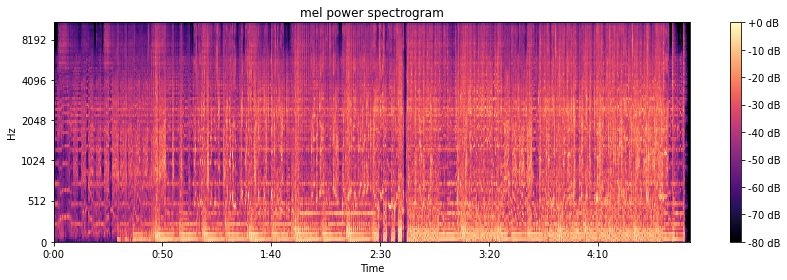

In [2]:
import numpy as np
import matplotlib.pyplot as plt

y = dataset['mp3/ACDC.mp3']

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)

print(f"Spectrogram shape: {S.shape}")

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## 1.3. Forming constellations

We will do something like this from our spectrogram. Not exactly as in the paper, but very similar :)

<img src="http://coding-geek.com/wp-content/uploads/2015/05/shazam_filtered_spectrogram-min.png" width="400"/>

This will include:
- get spectrogram
- find local maxima with [computer vision algrithm (wow!)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html): run maximum filtering and then compare original values with filtered.
- `ndimage.label()` labels different connected components
- `ndimage.find_objects()` returns their coordinates
- for each connected component of size 1 (`(dx.stop - dx.start) * (dy.stop - dy.start) == 1`) save a center, which will correspond to a "star".

We do this last step with filtering because silence parts and low frequency components in a spectrogram can form areas with the same amplitude values (~zeros). They glue together and if they are indexed for a track, this can drop search accuracy: better loose some real data points rather than add some incorrect.

Time resolution: 0.02321972427354941
mp3/ACDC.mp3


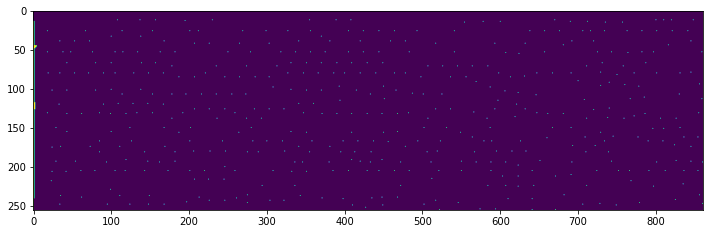

6587
mp3/iamthemorning.mp3


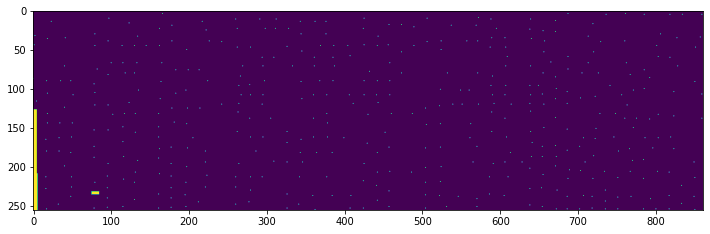

5128
mp3/Little Big.mp3


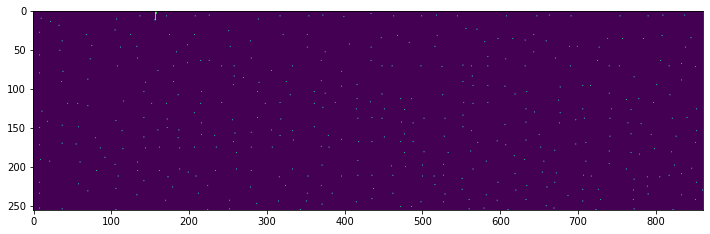

3479
mp3/request.mp3


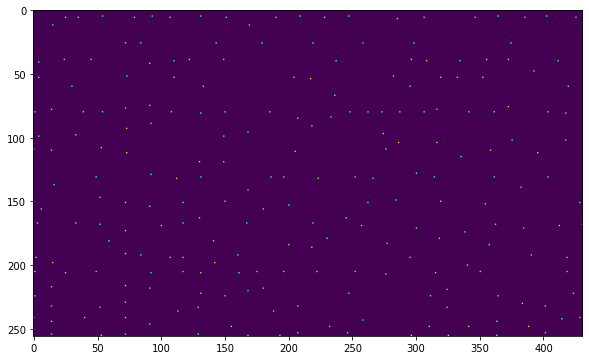

234


In [3]:
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
neighborhood_size = 20

# sec/sample - constant for all files
wav = dataset["mp3/ACDC.mp3"]
time_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
print("Time resolution:", time_resolution)

def form_constellation(name, wav, sample_rate, time_resolution):
    S = librosa.feature.melspectrogram(wav, sr=sample_rate, n_mels=256, fmax=4000)
    S = librosa.power_to_db(S, ref=np.max)
    # get local maxima
    Sb = maximum_filter(S, neighborhood_size) == S
    
    Sbd, num_objects = ndimage.label(Sb)
    objs = ndimage.find_objects(Sbd)
    points = []
    for dy, dx in objs:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2    
        if (dx.stop - dx.start) * (dy.stop - dy.start) == 1:
            points.append((x_center, y_center))
            
    # 20 seconds
    low = int(0 / time_resolution)
    hi = int(20 / time_resolution)
    print(name)
    # here we show results of max filter. This is NOT exactly the same which is saved.
    # Only single-point CC will fall into `points` array
    plt.figure(figsize=(12,6))
    plt.imshow(Sb[:, low:hi])
    plt.show()
    print(len(points))
    return sorted(points) 
    

constellations = {}
for name, wav in dataset.items():
    constellations[name] = form_constellation(name, wav, sample_rate, time_resolution)

request_constellation = form_constellation(request_audio, request_data, sample_rate, time_resolution)

## 1.4. [50+10] Build index from constellations 

### 1.4.1. [30] Index construction

Here you will build an in-memory index from constellations. Follow the algorithm:
1. For every "star" $(t_1, f_1)$ on constellation consider some constellation window (`target`) of time and frequency shift. In example this is `(+1, +5) sec` and `(-50, +50) Hz`, derived from original paper. In original paper they propose to use SOME "stars", not all. If you propose your own selection method - this is also good, as it speeds up computations. Otherwise just keep ALL stars from the window.
2. If a "star" $(t_2, f_2)$ falls into a `target` window, create or update and index entry. Form a key as $(f1, f2, \Delta t=t_2-t_1)$, and a value is $(t_1, filename)$.

Testing which way is working faster

In [4]:
a = {}
for i in range(100000):
    a[i] = 100*i

In [5]:
%timeit 1000000000000000000000 in a
%timeit 1000000000000000000000 in a.keys()
%timeit a.get(1000000000000000000000)

85.9 ns ± 1.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
159 ns ± 4.13 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
107 ns ± 1.45 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:
print(time_resolution)
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)    # start, end, Hz low, Hz high 

index = {}
request = {}

def within(freq1, freq2):
    return abs(freq1-freq2) <= target[3]

def update_index(idx, name, freq1, freq2, diff, t1):
    key = (freq1, freq2, diff)
    if key in idx:
        idx[key].append((t1, name))
    else:
        idx[key] = [(t1, name)]

def build_constellation_index(constellation_collection, target):
    # TODO: build shazam index for a collection of constellations
    # consider some window (target) for every point
    # for every point inside this window make an entry in the index (or update it, if the key exists)
    # keys are triples of the form (f1, f2, dt), values are lists with tuples (t, name)
    result_index = {}
    for key in constellation_collection.keys():
        points = constellation_collection[key]
        for i in range(len(points)):
            t1 = points[i][0]
            freq1 = points[i][1]
            for j in range(i+1, len(points)):
                t2 = points[j][0]
                if t2 != t1:
                    diff = t2-t1
                    if diff < target[1] and  diff >= target[0]:
                        freq2 = points[j][1]
                        if within(freq1, freq2):
                            update_index(result_index, key, freq1, freq2, diff, t1)
        print(f'{key}: Done')
    return result_index

index = build_constellation_index(constellations, target)
request = build_constellation_index({request_audio:request_constellation}, target)

0.02321972427354941
mp3/ACDC.mp3: Done
mp3/iamthemorning.mp3: Done
mp3/Little Big.mp3: Done
mp3/request.mp3: Done


### 1.4.2. [20] Compare `request.mp3` track with the database using index queries.

1. For every audio file from index find all keys that match query keys.
2. for every such match calculate time offset (difference between audio $t_1$ and query $t_1$)
3. Display counts of matches for every time offset (using histogram, for example)

In [7]:
# TODO for every audio find all keys that match request audio keys 
# for every such match calculate time offset (difference between audio and request)
# display counts of matches for every time offset (using histogram, for example)

from matplotlib import pyplot as plt

items = set(request.keys()).intersection(set(index.keys()))
result = {}
for item in items:
    req_point = request[item][0]
    req_time = req_point[0]
    dict_points = index[item]
    for point in dict_points:
#         print(point)
        time = point[0]
        name = point[1]
        dt = time - req_time
        if name not in result:
            result[name] = []
        result[name].append(dt)

mp3/ACDC.mp3


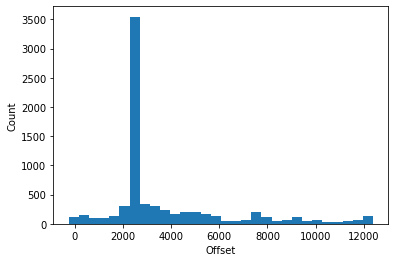

mp3/iamthemorning.mp3


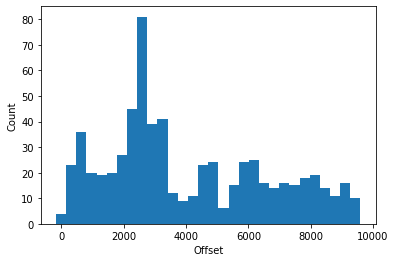

mp3/Little Big.mp3


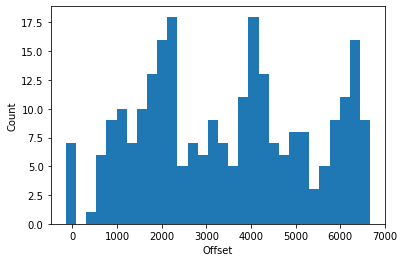

In [8]:
for key in result.keys():
    print(key)
    graph = result[key]
    plt.hist(graph, bins=30)
    plt.xlabel('Offset')
    plt.ylabel('Count')
    plt.show()

## 1.4.3. [+10] Similarity function

Implement a function, which will be estimating similarity of 2 audio tracks in some numbers. It should return 2 numbers: relevance estimation and audio offset (how start of one track is shifted with respect to another, if possible).

We are not giving any particular instructions on HOW to do this, but you can definitely start thinking from:
1. Norming and thresholding.
2. [Mode](https://en.wikipedia.org/wiki/Mode_(statistics)). E.g. [in python](https://docs.python.org/3/library/statistics.html).
3. [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis). E.g. [in python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html).

In [ ]:
def similarity(audio1, audio2):
    
    
    # ... write your code here
    similarity = None
    offset = None
    return similarity, offset


sim, off = similarity('mp3/ACDC.mp3', 'mp3/request.mp3')
assert abs(abs(off) - 60) < 5, "Offset value for these 2 tracks should be around 1 minute."

# 2. [50] Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## 2.1. Get dataset

We will use `Caltech 101` dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## 2.2. SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images (use in your code `cv.drawMatches()` function to display keypoint matches).

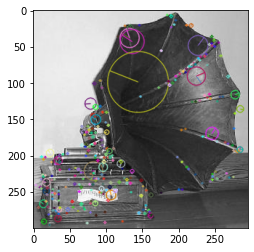

In [9]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = '101_ObjectCategories'
img = cv.imread(img_dir + '/gramophone/image_0018.jpg')
gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## 2.3. [50] Index of keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dimensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, you will index descriptors of all images using some data structure for approximate nearest neighbors search, such as Navigable Small World, Annoy, FAISS, .... Then, for a new (query) image you will compute its descriptors, and for each of them find `k` nearest neighbor descriptors from index (using Euclidean or Cosine distance). Finally, you will sort images (retrieved from neighbor descriptors) by frequency with which they appear in `k` nearest neighbors (more matches -- higher the rank).

### 2.3.1. [20] Build an index

#Read all images, saving category information. For every image generate SIFT descriptors and index them using HNSW from [`nmslib`](https://github.com/nmslib/nmslib), [FAISS](https://github.com/facebookresearch/faiss), [Annoy](https://github.com/spotify/annoy) or whatever.

In [10]:
## TODO do your job here
## key is a descriptor, value is a filename

# Index index[vector] -> idx:


# Using code from the contest and reworking it in some parts

import os
from annoy import AnnoyIndex
# Copied and adapted code from the Contest
def load_dataset_part(folder):
    result = []
    files = os.listdir(folder)
    for i in files:
        fn = os.path.join(folder, i)
        if os.path.isfile(fn):
            img = cv.cvtColor(cv.imread(fn), cv.COLOR_BGR2GRAY)
            result.append(img)
        else:
            print(fn)
    return result, files


def load_dataset(folder):
    X = []
    y = []
    fnames = []
    categories = os.listdir(folder)
    for category in categories:
        data, f = load_dataset_part(os.path.join(folder, category))
        X += data
        y += [category] *len(data)
        fnames += f
    return X, y, fnames

X, y, fnames = load_dataset('101_ObjectCategories')

In [11]:
print(len(y), len(fnames), len(X))

9145 9145 9145


In [12]:
sift = cv.xfeatures2d.SIFT_create()
X_sift = [sift.detectAndCompute(x, None)[1] for x in X]

In [13]:
# Jupyter once created a checkpoint in strawberries folder and this test was wrong
for i in range(len(y)):
    if y[i] == 'strawberry' and fnames[i] == 'image_0022.jpg':
        img = cv.cvtColor(cv.imread(os.path.join(img_dir, 'strawberry', 'image_0022.jpg')), cv.COLOR_BGR2GRAY)
        sas, s = sift.detectAndCompute(img, None)
        print(len(s), len(X_sift[i]))

197 197


There is a single picture, that has NO features and it is (At least for my library):

In [14]:
for j in range(len(X_sift)):
    if X_sift[j] is None:
        print(f"No features found for: {y[j]}/{fnames[j]}, index - {j}")

No features found for: BACKGROUND_Google/image_0031.jpg, index - 969


Therefore, I will exclude it from the index and from the files, because it is not used anywhere in the queries (Annoy ругается)

In [15]:
X_sift = X_sift[:969] + X_sift[970:]
y = y[:969] + y[970:] 
fnames = fnames[:969] + fnames[970:]

In [16]:
# Sanity test (У меня беды с башкой)
img = cv.cvtColor(cv.imread(os.path.join(img_dir, y[10], fnames[10])), cv.COLOR_BGR2GRAY)
sas, s = sift.detectAndCompute(img, None)
print(len(s), len(X_sift[10]))

734 734


In [17]:
index = AnnoyIndex(128, 'angular')  
# Unfortunately Annoy allocates only memory for indeces in range[0;n-1], n - number of vectors
# My index of vector is hash(str(vec)), so I need additional map to convert:
# indeces[idx] -> vec_idx
# labels[vec_idx] -> [list of possible images]
vec_to_file = {}

for i in range(len(X_sift)):
    for vec in X_sift[i]:
        vec_to_file[j] = i
        index.add_item(j, vec)
        j+=1
    
# Building dictionary:
index.build(10)

True

### 2.3.2. [20] Implement search function

Implement a function which returns `k` neighbours (file names) sorted by similarity for a given query image name. If `draw_results==True`, then it should also draw `k` pairs of images, where the original image is shown along with its neighbor and matching keypoints are visualized with `cv.drawMatches()` function, like this:

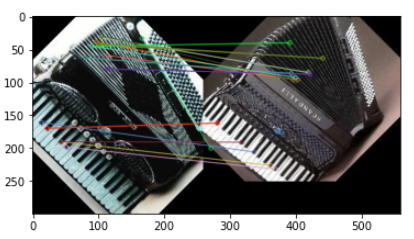

In [18]:
from matplotlib import pyplot as plt
    
def draw_matches(nns, img1, kp1, ds1):
    for nn in nns:
        # Code from the tutorial linked above (https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html)
        img2 = cv.cvtColor(cv.imread(os.path.join(img_dir, nn[1])), cv.COLOR_BGR2GRAY)
        kp2, ds2 = sift.detectAndCompute(img2,None)
        # BFMatcher with default params
        bf = cv.BFMatcher()
        matches = bf.knnMatch(ds1,ds2,k=2)
        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
        # cv.drawMatchesKnn expects list of lists as matches.
        img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3,),plt.show()

def transform(dictionary):
    result = []
    for key in dictionary.keys():
        filename = y[key] + '/' + fnames[key]
        similarity = dictionary[key]
        result.append((similarity, filename))
    return sorted(result, reverse=True)
        
def anns(imagename, k, draw_results=False):
    img = cv.cvtColor(cv.imread(os.path.join(img_dir, imagename)), cv.COLOR_BGR2GRAY)
    kp1, ds1 = sift.detectAndCompute(img,None)
    res = {}
    for vector in ds1:
        nns = index.get_nns_by_vector(vector, k)
        for nn in nns:
            f_ind = vec_to_file[nn]
            if f_ind not in res:
                res[f_ind] = 1
            else:
                res[f_ind] += 1
    result = transform(res)[:k]
    if draw_results:
        draw_matches(result, img, kp1, ds1)
    return result


# finds query image in the result, as it is indexed
filename = 'strawberry/image_0022.jpg'
assert any([f[1] == filename for f in anns(filename, 10)]), "Should return a duplicate"

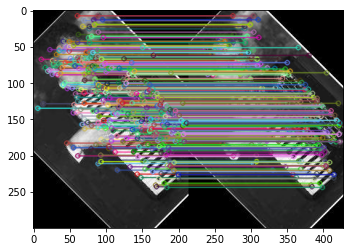

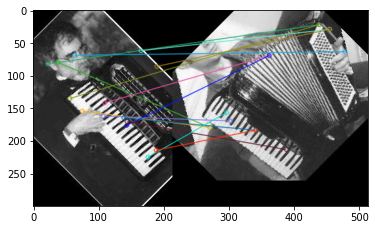

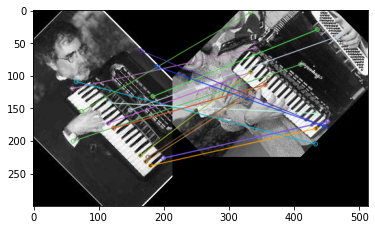

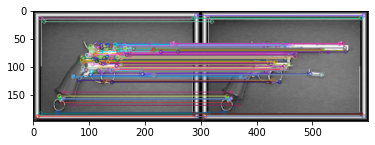

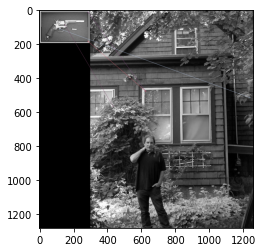

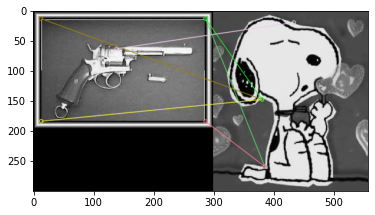

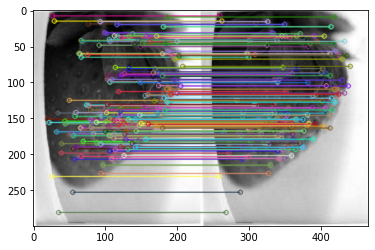

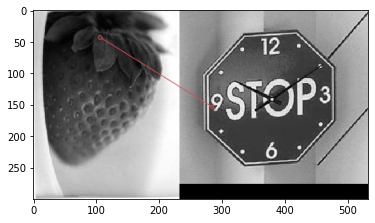

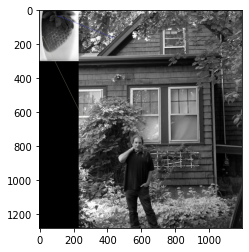

In [19]:
# visual test
query_images = [
    'accordion/image_0043.jpg',
    'revolver/image_0043.jpg',
    'strawberry/image_0022.jpg'
]

# draws results for every query image
for query_image in query_images:
    anns(query_image, 3, draw_results=True)

## 2.3.3. [10] Estimate quality

Find 10 closest neighbors for every image below.
```
accordion/image_0043.jpg
laptop/image_0052.jpg
pagoda/image_0038.jpg
revolver/image_0043.jpg
rhino/image_0040.jpg
sea_horse/image_0038.jpg
soccer_ball/image_0057.jpg
starfish/image_0011.jpg
strawberry/image_0022.jpg
wrench/image_0013.jpg
```
Consider `relevant` if **class of the query and class of the result match**. Compute `DCG` for every query and for the bucket. Print your results, but please **don't draw them** so that the notebook doesn't grow too big (or remove image output before submission).

In [20]:
## write your code here
import math

queries = [ 'accordion/image_0043.jpg',
            'laptop/image_0052.jpg',
            'pagoda/image_0038.jpg',
            'revolver/image_0043.jpg',
            'rhino/image_0040.jpg',
            'sea_horse/image_0038.jpg',
            'soccer_ball/image_0057.jpg',
            'starfish/image_0011.jpg',
            'strawberry/image_0022.jpg',
            'wrench/image_0013.jpg',
          ]
# Re-Using the code from the previous assignments (1 and 4)
def dcg_relevance(place, relevance=1):
    return (2**relevance - 1)/math.log2(1 + place)


def dcg(rels):
    #TODO compute DCG@5
    res = 0
    for place in rels:
    # Sum up only the relevant docs, because non-relevant yield 0
        res+=dcg_relevance(place)
    return res

assessment = []

for q in queries:
    group = q.split('/')[0]
    neighbours = anns(q, 10)
    relevant = []
    for i in range(len(neighbours)):
        n_group = neighbours[i][1].split('/')[0]
        if group == n_group: 
            relevant.append(i+1)
    assessment.append(relevant)
            
print(sum([dcg(row) for row in assessment]) / len(assessment))

1.4304487788978515
